In [1]:
import os
import json
import random
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
from sklearn import metrics
from IPython.display import Image
from sklearn.model_selection import train_test_split


In [2]:
dt = "/Users/ivan/Desktop/ALL/Data/CVmchar"

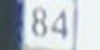

In [3]:
ix, iy = 100, 50

def fimg(img):
    return cv.resize(img, (ix, iy))

img = fimg(cv.imread(f"{dt}/mchar_train/018292.png"))
cv.imwrite("tmp.jpg", img)
Image("tmp.jpg", height=300, width=300)


In [16]:
datax = []
datay = []

dtype = "mchar_train"

with open(f"{dt}/{dtype}.json", "r") as f:
    data = f.readlines()
json_file = data[0]
j_obj = json.loads(json_file)

heightl, widthl = [], []
data = []
for dti in tqdm(os.listdir(f"{dt}/{dtype}")[:]):
    f1dti = j_obj[dti]
    img = cv.imread(f"{dt}/{dtype}/{dti}")
    for top, height, left, width, label in zip(
        f1dti["top"], f1dti["height"], f1dti["left"], f1dti["width"], f1dti["label"]):
        top, height, left, width, label = int(top), int(height), int(left), int(width), int(label)
        top, height, left, width = max(top,0), max(height,0), max(left,0), max(width,0)
        
        widthl.append(width)
        heightl.append(height)
        
        img0 = fimg(img[top:top+height,left:left+width])
        datax.append(img0)
        datay.append(label)    

heightm, widthm = np.mean(heightl), np.mean(widthl)
"%.6f, %.6f" % (heightm, widthm)


100%|██████████| 30000/30000 [00:10<00:00, 2829.08it/s]


'33.854208, 16.640812'

In [5]:
%time rx = np.array(datax, dtype=np.float32)

%time ry = np.array(datay, dtype=np.int32)
print(pd.value_counts(ry))


CPU times: user 776 ms, sys: 758 ms, total: 1.53 s
Wall time: 1.53 s
CPU times: user 4.01 ms, sys: 1 µs, total: 4.01 ms
Wall time: 4.01 ms
1    12446
2     9532
3     7608
4     6720
5     6146
6     5141
7     5032
8     4510
0     4444
9     4186
dtype: int64


In [6]:
m_x = rx
m_y = ry

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


def tf_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(iy, ix, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        loss=tf.keras.losses.MAE, 
        optimizer="adam", 
        metrics=['accuracy']
    )
    return model

model = tf_model()
print(model.summary())

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('>', end='')
        if epoch % 100 == 0: 
            print('')

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
%time history = model.fit(m_x,m_y,epochs=EPOCHS,validation_split=0.5,verbose=0,callbacks=[early_stop, PrintDot()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 21, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 12096)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                7

In [7]:
import matplotlib.pyplot as plt


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('[AUC]')
    plt.plot(hist['epoch'], hist['accuracy'], label='Trar')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Vals')
    plt.legend()

plot_history(history)


In [8]:
n, m = 0, 0

dtype = "mchar_train"

with open(f"{dt}/{dtype}.json", "r") as f:
    data = f.readlines()
json_file = data[0]
j_obj = json.loads(json_file)

for dti in tqdm(os.listdir(f"{dt}/{dtype}")[:]):
    f1dti = j_obj[dti]
    img = cv.imread(f"{dt}/{dtype}/{dti}")
    for top, height, left, width, label in zip(
        f1dti["top"], f1dti["height"], f1dti["left"], f1dti["width"], f1dti["label"]):
        top, height, left, width, label = int(top), int(height), int(left), int(width), int(label)
        top, height, left, width = max(top,0), max(height,0), max(left,0), max(width,0)
        
        img0 = fimg(img[top:top+height,left:left+width])
        img0 = np.array([img0], dtype=np.float32)
        result = int(model.predict(img0)[0][0])
        
        n += 1 if result == label else 0
        m += 1

"%s, %d, %d, %.6f" % (dtype, n, m, n/m)


100%|██████████| 30000/30000 [18:40<00:00, 26.77it/s]


'mchar_train, 31432, 65765, 0.477944'

In [9]:
n, m = 0, 0

dtype = "mchar_val"

with open(f"{dt}/{dtype}.json", "r") as f:
    data = f.readlines()
json_file = data[0]
j_obj = json.loads(json_file)

for dti in tqdm(os.listdir(f"{dt}/{dtype}")[:]):
    f1dti = j_obj[dti]
    img = cv.imread(f"{dt}/{dtype}/{dti}")
    for top, height, left, width, label in zip(
        f1dti["top"], f1dti["height"], f1dti["left"], f1dti["width"], f1dti["label"]):
        top, height, left, width, label = int(top), int(height), int(left), int(width), int(label)
        top, height, left, width = max(top,0), max(height,0), max(left,0), max(width,0)
        
        img0 = fimg(img[top:top+height,left:left+width])
        img0 = np.array([img0], dtype=np.float32)
        result = int(model.predict(img0)[0][0])
        
        n += 1 if result == label else 0
        m += 1

"%s, %d, %d, %.6f" % (dtype, n, m, n/m)


100%|██████████| 10000/10000 [05:44<00:00, 29.01it/s]


'mchar_val, 8394, 19893, 0.421957'

In [12]:
dtype = "mchar_test_a"

for dti in tqdm(os.listdir(f"{dt}/{dtype}")[:10]):
    print(cv.imread(f"{dt}/{dtype}/{dti}").shape)


100%|██████████| 10/10 [00:00<00:00, 1182.03it/s]

(89, 395, 3)
(48, 64, 3)
(92, 139, 3)
(59, 82, 3)
(29, 32, 3)
(71, 89, 3)
(63, 86, 3)
(33, 64, 3)
(55, 64, 3)
(79, 190, 3)


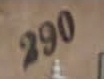

In [83]:
dtype = "mchar_test_a"
dname = "000001"
img = cv.imread(f"{dt}/{dtype}/{dname}.png")
cv.imwrite("tmp.jpg", img)
Image("tmp.jpg")


3


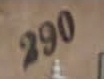

In [84]:
img = cv.imread(f"{dt}/{dtype}/{dname}.png")

img0 = fimg(img)
img0 = np.array([img0], dtype=np.float32)
result = int(model.predict(img0)[0][0])
print(result)

cv.imwrite("tmp.jpg", img)
Image("tmp.jpg")


In [85]:
n = 1

img = cv.imread(f"{dt}/{dtype}/{dname}.png")
_, y, _ = img.shape
img = img[:,y//5*(n-1):y//5*n]

img0 = fimg(img)
img0 = np.array([img0], dtype=np.float32)
result = int(model.predict(img0)[0][0])
print(result)

cv.imwrite("tmp.jpg", img)
Image("tmp.jpg")


1


In [86]:
n = 2

img = cv.imread(f"{dt}/{dtype}/{dname}.png")
_, y, _ = img.shape
img = img[:,y//5*(n-1):y//5*n]

img0 = fimg(img)
img0 = np.array([img0], dtype=np.float32)
result = int(model.predict(img0)[0][0])
print(result)

cv.imwrite("tmp.jpg", img)
Image("tmp.jpg")

4


In [87]:
n = 3

img = cv.imread(f"{dt}/{dtype}/{dname}.png")
_, y, _ = img.shape
img = img[:,y//5*(n-1):y//5*n]

img0 = fimg(img)
img0 = np.array([img0], dtype=np.float32)
result = int(model.predict(img0)[0][0])
print(result)

cv.imwrite("tmp.jpg", img)
Image("tmp.jpg")

2


In [88]:
n = 4

dtype = "mchar_test_a"
img = cv.imread(f"{dt}/{dtype}/000001.png")
_, y, _ = img.shape
img = img[:,y//5*(n-1):y//5*n]

img0 = fimg(img)
img0 = np.array([img0], dtype=np.float32)
result = int(model.predict(img0)[0][0])
print(result)

cv.imwrite("tmp.jpg", img)
Image("tmp.jpg")

8


In [89]:
n = 5

dtype = "mchar_test_a"
img = cv.imread(f"{dt}/{dtype}/000001.png")
_, y, _ = img.shape
img = img[:,y//5*(n-1):y//5*n]

img0 = fimg(img)
img0 = np.array([img0], dtype=np.float32)
result = int(model.predict(img0)[0][0])
print(result)

cv.imwrite("tmp.jpg", img)
Image("tmp.jpg")

2
